<a href="https://colab.research.google.com/github/tomoakism/dotfiles/blob/main/Geoguessr_pd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Google Driveをマウント

In [17]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd "/content/drive/My Drive/Geoguessrpd"

/content/drive/My Drive/Geoguessrpd


GPUに接続

In [ ]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [29]:
!nvidia-smi

Fri Jun 23 07:23:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |   2797MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------



---



データセットを読み込むためのクラス


In [24]:
from torch.utils.data import Dataset
from PIL import Image
import os

class StreetViewDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_filenames = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_name).convert('RGB')

        # ファイル名から座標を取り出す
        coord = self.image_filenames[idx].split('_')[:2]
        coord = [float(x) for x in coord]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(coord).to(device)

読み込んだ画像の処理

In [25]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

データセットを分割

In [26]:
from torch.utils.data import random_split

dataset = StreetViewDataset("./images", transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

データセットの読み込み

In [27]:
from torch.utils.data import DataLoader

batch_num = 64

train_loader = DataLoader(train_dataset, batch_size=batch_num, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_num, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_num, shuffle=True)

学習済みResNet-50モデルの作成

In [28]:
from torchvision import models

model = models.resnet50(pretrained=True)

# 事前学習済みのレイヤーを固定
for param in model.parameters():
    param.requires_grad = False

# 最終レイヤーを変更
model.fc = torch.nn.Linear(model.fc.in_features, 2)

model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ファインチューニング

In [30]:
import torch.optim as optim

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters())

train_losses = []
val_losses = []



---

学習済みモデルを読み込む


Batch 256

In [ ]:
checkpoint = torch.load('model_256.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [ ]:
import pickle

f = open('./train_loss_list.txt','rb')
train_losses = pickle.load(f)

f = open('./val_loss_list.txt','rb')
val_losses = pickle.load(f)

Batch 64

In [31]:
checkpoint = torch.load('model_64.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [32]:
import pickle

f = open('./train_loss_list_64.txt','rb')
train_losses = pickle.load(f)

f = open('./val_loss_list_64.txt','rb')
val_losses = pickle.load(f)



---



In [34]:
num_epochs = 10

In [35]:
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    model.train()
    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

Epoch 1, Train Loss: 2635.195613236861, Validation Loss: 2523.9376678466797
Epoch 2, Train Loss: 2634.5179643110796, Validation Loss: 2529.7439626057944
Epoch 3, Train Loss: 2629.3473510742188, Validation Loss: 2570.2941538492837
Epoch 4, Train Loss: 2619.934616921165, Validation Loss: 2541.1630655924478
Epoch 5, Train Loss: 2616.2887961647725, Validation Loss: 2555.2272338867188
Epoch 6, Train Loss: 2608.2193592418325, Validation Loss: 2534.7966918945312
Epoch 7, Train Loss: 2600.414014781605, Validation Loss: 2539.5494384765625
Epoch 8, Train Loss: 2602.646240234375, Validation Loss: 2519.0567932128906
Epoch 9, Train Loss: 2590.5395962801845, Validation Loss: 2522.960194905599
Epoch 10, Train Loss: 2593.0158813476564, Validation Loss: 2510.0174001057944


ロスをプロット

In [36]:
print(f"Training losses: {train_losses}")
print(f"Validation losses: {val_losses}")
print(len(train_losses))

Training losses: [3437.773965731534, 3327.0638117009944, 3248.3892134232956, 3182.6600186434657, 3138.616439541903, 3093.091679243608, 3055.4022061434657, 3010.686492365057, 2983.342549272017, 2944.340234375, 2925.102743252841, 2909.987462269176, 2896.4831099076705, 2858.5384055397726, 2848.3869273792616, 2827.5058061079544, 2812.308085493608, 2790.148643909801, 2779.9727195046166, 2761.046179199219, 2760.966396262429, 2745.0953579989346, 2741.6004583185368, 2727.4944446910513, 2713.8450417258523, 2708.930939275568, 2707.578085049716, 2679.2102683327416, 2678.9891046697444, 2670.405536443537, 2669.9269309303977, 2666.2084361683237, 2654.400702459162, 2640.55029296875, 2631.2712757457384, 2636.124168812145, 2633.859832208807, 2640.8598876953124, 2616.7219959605823, 2616.31718528054, 2635.195613236861, 2634.5179643110796, 2629.3473510742188, 2619.934616921165, 2616.2887961647725, 2608.2193592418325, 2600.414014781605, 2602.646240234375, 2590.5395962801845, 2593.0158813476564]
Validation 

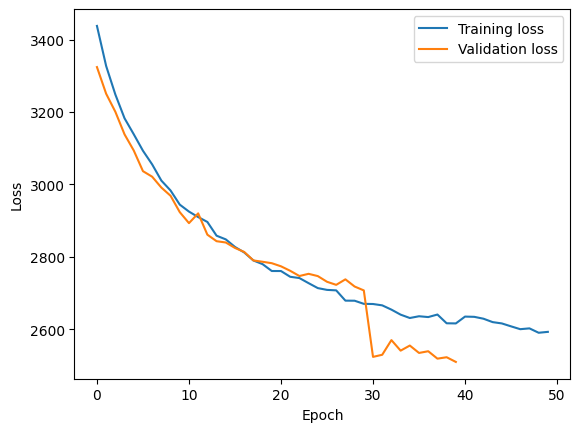

In [37]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

モデルをセーブ

Batch 256

In [ ]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}
torch.save(checkpoint, 'model_256.pth')


In [ ]:
import pickle
f = open('./train_loss_list.txt', 'wb')
list_row = train_losses
pickle.dump(list_row, f)

f = open('./val_loss_list.txt', 'wb')
list_row = val_losses
pickle.dump(list_row, f)


batch 64

In [38]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}
torch.save(checkpoint, 'model_64_50epch.pth')


In [39]:
import pickle
f = open('./train_loss_list_64_50epch.txt', 'wb')
list_row = train_losses
pickle.dump(list_row, f)

f = open('./val_loss_list_64_50epch.txt', 'wb')
list_row = val_losses
pickle.dump(list_row, f)


モデルのテスト

モデルをチェックポイントからロード

In [ ]:
checkpoint = torch.load('model_256.pth')
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
model = model.to(device)
model.eval()

total_loss = 0

# テストデータを学習済みモデルでテスト
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)

avg_loss = total_loss / len(test_loader.dataset)

print('Test Loss:', avg_loss)

単一画像の予測

In [ ]:
image_path = 'path_to_your_image.jpg'
image = Image.open(image_path).convert('RGB')
image = transform(image)
image = image.unsqueeze(0)
image = image.to(device)

In [ ]:
model.eval()
with torch.no_grad():
    prediction = model(image)